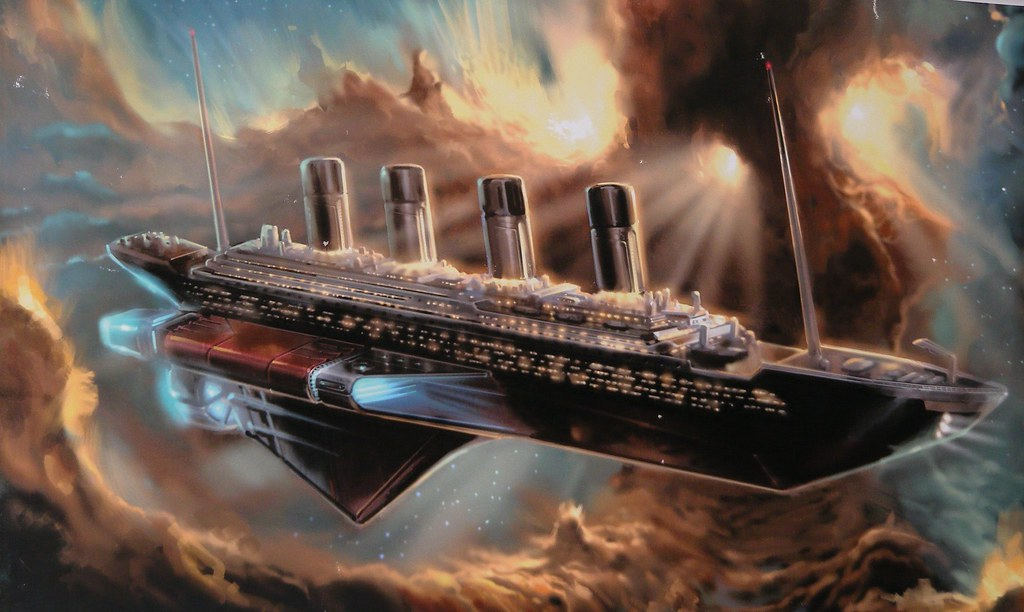

#Table of Contents:

1.Import

2.Exploratory Data Analysis (EDA)

3.Data Cleaning and Feature Engineering

4.Accuracy of different models

5.Submission

#1.Import

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
root_dir = '/kaggle/input/spaceship-titanic'
files = os.path.join(root_dir)
filenames = os.listdir(files)
print(filenames)

#2.Exploratory Data Analysis (EDA)

In [ ]:
#let's download the training data and take a look at it
train_data = pd.read_csv(os.path.join(root_dir,'train.csv'))
train_data.head()

In [ ]:
#let's download the testing data and take a look at it
test_data = pd.read_csv(os.path.join(root_dir,'test.csv'))
test_data.head()

In [ ]:
print((f"Training data"),"-----> Rows:",train_data.shape[0], " ||| ", "Colomns:",train_data.shape[1])
print((f"Test data"),"    -----> Rows:",test_data.shape[0], " ||| ", "Colomns:",test_data.shape[1])

In [ ]:
train_data.info()

In [ ]:
train_data.describe(include='all')

#3.Data Cleaning and Feature Engineering

In [ ]:
train_data.isna().any()

In [ ]:
def missingValues(df):
    percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)
    count = df.isna().sum().sort_values(ascending=False)
    diff = pd.concat([count,percentage],axis=1,keys=['Null Count','Null Percentage'])
    return diff

In [ ]:
nan_feats_tr = train_data.columns[train_data.isna().any()].tolist()
n_nans_tr = train_data[nan_feats_tr].isna().sum()
print(f"Training Set\nMissing Values:\n{n_nans_tr}")
plt.figure(figsize=(14,5))
plt.title("Training Set - Missing Values")
sns.barplot(y=n_nans_tr,x=nan_feats_tr, palette='viridis')

In [ ]:
plt.figure(figsize=(14,5))
sns.displot(
    data=train_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette='viridis'
)
plt.title("Training Set - Missing Values Distribution")

In [ ]:
missingValues(train_data)

In [ ]:
nan_feats_te = test_data.columns[test_data.isna().any()].tolist()
n_nans_te = test_data[nan_feats_te].isna().sum()
print(f"Testing Set\nMissing Values:\n{n_nans_te}")
plt.figure(figsize=(14,5))
plt.title("Testing Set - Missing Values")
sns.barplot(y=n_nans_te,x=nan_feats_te, palette='viridis')

In [ ]:
plt.figure(figsize=(14,5))
sns.displot(
    data=test_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette='viridis'
)
plt.title("Testing Set - Missing Values Distribution")

In [ ]:
missingValues(test_data)

In [ ]:
#let's create 2 new features: aaaa and bb
aaaa_bb = train_data['PassengerId'].apply(lambda x: x.split('_')).values
aaaa = list(map(lambda x: x[0], aaaa_bb))
bb = list(map(lambda x: x[1], aaaa_bb))
train_data['aaaa'] = aaaa
train_data['bb'] = bb
train_data['bb'] = train_data['bb'].astype('int64')

In [ ]:
mode = train_data["aaaa"].mode()[0]
maxP_inGroup = len(train_data[train_data["aaaa"] == mode])
print("The maximum number of passengers in a single group is",maxP_inGroup)

In [ ]:
train_data[train_data["aaaa"] == mode] # let's make sure

In [ ]:
for i in range(maxP_inGroup):
    curr_aaaa = train_data[train_data['bb'] == i + 1]['aaaa'].to_numpy()
    train_data.loc[train_data['aaaa'].isin(curr_aaaa), ['group_size']] = i + 1

plt.figure(figsize=(12,8))
print(colored("Value Counts based on the group size:\n", 'cyan', attrs=['underline', 'bold']))
print(colored("Gr. size, Count", 'blue', attrs=['bold']))
print(train_data['group_size'].value_counts())
sns.barplot(y=train_data['group_size'].value_counts(), x=np.unique(train_data['bb']), palette='viridis')
plt.show()
sns.catplot(x="group_size",  kind="count", hue='Transported', data=train_data, palette='viridis').set(title='Group Size and Transported Count')
plt.show()

In [ ]:
aaaa_bb = test_data['PassengerId'].apply(lambda x: x.split('_')).values
aaaa = list(map(lambda x: x[0], aaaa_bb))
bb = list(map(lambda x: x[1], aaaa_bb))
test_data['aaaa'] = aaaa
test_data['bb'] = bb
test_data['bb'] = test_data['bb'].astype('int64')

In [ ]:
mode = test_data["aaaa"].mode()[0]
maxP_inGroup = len(test_data[test_data["aaaa"] == mode])
print("The maximum number of passengers in the same group is",maxP_inGroup)

In [ ]:
test_data['group_size'] = 0
for i in range(maxP_inGroup):
    curr_aaaa = test_data[test_data['bb'] == i + 1]['aaaa'].to_numpy()
    test_data.loc[test_data['aaaa'].isin(curr_aaaa), ['group_size']] = i + 1

plt.figure(figsize=(12,8))
print(colored("Value Counts based on the group size:\n", 'cyan', attrs=['underline', 'bold']))
print(colored("Gr. size, Count", 'blue', attrs=['bold']))
print(test_data['group_size'].value_counts())
sns.barplot(y=test_data['group_size'].value_counts(), x=np.unique(test_data['bb']), palette='viridis')
plt.show()

In [ ]:
train_data.head()

In [ ]:
print(len(train_data[train_data["group_size"] == 1]))
print(len(train_data[train_data["group_size"] != 1]))

In [ ]:
#let's create a new feature InGroup to indicate if a passenger is alone or in group
train_data["InGroup"] = train_data["group_size"]==1
test_data["InGroup"] = test_data["group_size"]==1

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
train_data["Deck"] = train_data["Cabin"].apply(lambda x: str(x).split("/")[0] if(np.all(pd.notnull(x))) else x)
test_data["Deck"] = test_data["Cabin"].apply(lambda x: str(x).split("/")[0] if(np.all(pd.notnull(x))) else x)
train_data["Num"] = train_data["Cabin"].apply(lambda x: int(str(x).split("/")[1]) if(np.all(pd.notnull(x))) else x)
test_data["Num"] = test_data["Cabin"].apply(lambda x: int(str(x).split("/")[1]) if(np.all(pd.notnull(x))) else x)
train_data["Side"] = train_data["Cabin"].apply(lambda x: str(x).split("/")[2] if(np.all(pd.notnull(x))) else x)
test_data["Side"] = test_data["Cabin"].apply(lambda x: str(x).split("/")[2] if(np.all(pd.notnull(x))) else x)

In [ ]:
#let's save PassengerId for the submission
Id_test_list = test_data["PassengerId"].tolist()
#let's delete useless features
train_data.drop("PassengerId",axis=1,inplace=True)
test_data.drop("PassengerId",axis=1,inplace=True)
train_data.drop("Cabin",axis=1,inplace=True)
test_data.drop("Cabin",axis=1,inplace=True)
train_data.drop("Name",axis=1,inplace=True)
test_data.drop("Name",axis=1,inplace=True)
train_data.drop("aaaa",axis=1,inplace=True)
test_data.drop("aaaa",axis=1,inplace=True)
train_data.drop("bb",axis=1,inplace=True)
test_data.drop("bb",axis=1,inplace=True)
train_data.drop("group_size",axis=1,inplace=True)
test_data.drop("group_size",axis=1,inplace=True)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
train_data.dtypes

In [ ]:
num_feats = list(train_data.select_dtypes(include='number'))
categ_feats = list(train_data.select_dtypes(exclude='number'))
test_categ_feats = list(test_data.select_dtypes(exclude='number'))
print("Numerical features:",num_feats)
print("Categorical features (training set):", categ_feats)
print("Categorical features (testing set):",test_categ_feats)

In [ ]:
#let's replace missing values in each numerical feature with the median
for feat in num_feats:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

#let's replace missing values in each categorical feature with the most frequent value
for feat in categ_feats:
    train_data[feat].fillna(train_data[feat].value_counts().index[0],inplace=True)
    
for feat in test_categ_feats:
    test_data[feat].fillna(test_data[feat].value_counts().index[0],inplace=True)

In [ ]:
# let's make sure
print(colored("Training Set\n",attrs=['bold']), missingValues(train_data),end="\n\n")
print(colored("Testing Set\n",attrs=['bold']), missingValues(test_data),end="\n\n")

In [ ]:
#let's print categories of each categorical column after removing unnecessary columns
for col in train_data.select_dtypes(exclude=['number']):
  print(f'{col:-<30},{train_data[col].unique()}')

In [ ]:
#let's plot distribution of categorical columns
colors =sns.color_palette('viridis', 7)

fig = plt.figure(figsize= (15,10))
for i, col in enumerate(categ_feats):
    ax=fig.add_subplot(3, 3, i+1)
    sns.countplot(x=train_data[col],palette=colors, ax=ax)

fig.tight_layout()  
plt.show()

In [ ]:
print("Number of numerical features:",len(num_feats))
num_feats

In [ ]:
sns.set()
fig, axes = plt.subplots(len(num_feats), len(num_feats),figsize=(20, 20))
fig.suptitle('Correlation between numerical features', fontsize=24)
for i,col1 in enumerate(num_feats):
    for j,col2 in enumerate(num_feats):
        sns.regplot(x=col1,y=col2,data=train_data,color='blue', scatter_kws={
                    "color": "darkblue"}, line_kws={"color": "yellow"}, ax=axes[i,j])
fig.tight_layout()
plt.subplots_adjust(top=0.90)

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data[num_feats].corr(),cmap='Purples',annot=True)
plt.title ('Correlation HeatMap', fontsize=20)
plt.show()

In [ ]:
train_data.columns

In [ ]:
train_data.dtypes

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
LABELS = test_data.columns
encoder = LabelEncoder()
for col in LABELS:
    # Check if object
    if train_data[col].dtype == 'O':
        train_data[col] = encoder.fit_transform(train_data[col]) #fit label encoder and return encoded labels.
        test_data[col] = encoder.transform(test_data[col]) #transform labels to normalized encoding
        
    elif train_data[col].dtype == 'bool':
        train_data[col] = train_data[col].astype('int')
        test_data[col] = test_data[col].astype('int')

train_data['Transported'] = train_data['Transported'].astype('int')
LABELS_MM = ['Age']
LABELS_SS = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
mm_scaler = MinMaxScaler() #default=(0,1)
ss_scaler = StandardScaler()
# Apply Min-Max Scaling
train_data[LABELS_MM] = mm_scaler.fit_transform(train_data[LABELS_MM])
test_data[LABELS_MM] = mm_scaler.transform(test_data[LABELS_MM])
# Apply Standard Scaling
train_data[LABELS_SS] = ss_scaler.fit_transform(train_data[LABELS_SS])
test_data[LABELS_SS] = ss_scaler.transform(test_data[LABELS_SS])

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
x=train_data[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'InGroup',
       'Deck', 'Num', 'Side']]
y=train_data['Transported']

In [ ]:
x.head()

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_data.corr(), annot=True, cmap='Purples')

#4.Accuracy of different models

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)
X_train.dtypes

In [ ]:
params = { 'max_depth': [2,3,6],
          'gamma': [0,1],
          'learning_rate': [0.05, 0.1, 0.5],
          'n_estimators': [200, 500, 800],
          'colsample_bytree': [0.1, 0.3, 0.5]}

xgb_clf = XGBClassifier(seed = 48)

xgb_grid = GridSearchCV(estimator=xgb_clf, param_grid=params, cv=3)

xgb_grid.fit(X_train,y_train)

In [ ]:
accXGB = accuracy_score(xgb_grid.predict(X_test),y_test)
print(accXGB)
print(xgb_grid.best_params_)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
accKNN = knn.score(X_test, y_test)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
accLogreg = logreg.score(X_test, y_test)

In [ ]:
linear_svm = LinearSVC()
linear_svm.fit(X_train, y_train)
accLinsvm = linear_svm.score(X_test, y_test)

In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
accTree = tree.score(X_test, y_test)

In [ ]:
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)
accForest = forest.score(X_test, y_test)

In [ ]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
accGbrt = gbrt.score(X_test, y_test)

In [ ]:
models = pd.DataFrame({
    'Model': ['KNeighbors', 'LogisticRegression', 'LinearSVC', 
              'DecisionTree', 'RandomForest', 
              'GradientBoosting', 'XGBoosting'],
    'Score': [accKNN, accLogreg, accLinsvm, accTree, accForest, accGbrt, accXGB]})
models.sort_values(by='Score', ascending=False)

#5.Submission

In [ ]:
pred=pd.Series(xgb_grid.predict(test_data)).map({0:False, 1:True})
len(pred)

In [ ]:
submission = pd.DataFrame({'PassengerId': Id_test_list,
                       'Transported': pred})
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)
print("Submission was successfully saved!")